In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import os
import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-g6ppwc3z
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-g6ppwc3z
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=eadbfba41082870c37546b150ef3ca0f358f28178a28e2e18bb30e340e5fb62d
  Stored in directory: /tmp/pip-ephem-wheel-cache-hk7ww6hk/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import tensorflow as tf

### Import plotting utilities and planar drone locally or from github

In [4]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')

extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

We begin assuming that we have the following measurements, which could come from a camera (ventral optic flow) and IMU. The acceleration measurements must be defined by the dynamics equations.

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[red]{\ddot{x}} \\[0.3em]
\bbox[red]{\ddot{z}} \\[0.3em]
\end{bmatrix} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix} +
\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
\end{bmatrix} \bbox[lightgreen]{j_2}
$

# Dynamics and measurement functions

In [5]:
f = planar_drone.F().f
h = planar_drone.H('h_camera_imu').h

In [6]:
print(f(None, None, return_state_names=True))

['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']


In [7]:
print(h(None, None, return_measurement_names=True))

['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']


# Run MPC simulation

In [8]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, dt=0.1, tsim_length=20, trajectory_shape='alternating')

### plot the x, z trajectory

Text(0, 0.5, 'z pos')

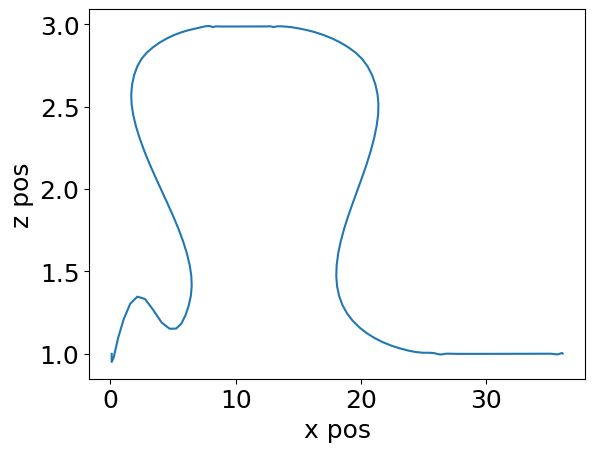

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [10]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

In [11]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow'>

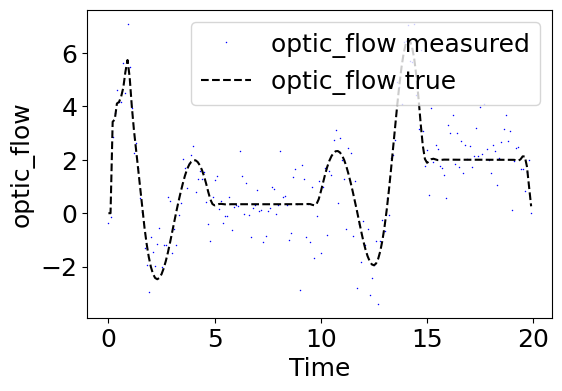

In [12]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

In [13]:
#plot_tme(t_sim, y_sim['accel_x'], y_noisy['accel_x'], label_var='accel_x')

### Save data as dataframes

In [14]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

We will use the same R and Q as before.

In [16]:
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-4]*len(x_sim))

In [17]:
dt = np.mean(np.diff(t_sim))

# First let's break the UKF

The UKF (and any nonlinear KF implementation) is only mathematically sound if the state estimates are accurate. If we start with a vastly incorrect initial state the filter can get off track and never recover.

Here we choose a very wrong initial condition, and run everything else as before.

Notice how the estimates for the altitude run off to infinity. Bad news.

In [18]:
x0 = 10*np.ones(len(x_sim))*2 # <<< Note these initial values are all very wrong!
u0 = np.zeros(2)
P0 = np.eye(len(x_sim))*1 # <<< This is relatively small, otherwise the filter can go unstable

In [19]:
UKF = unscented_kalman_filter.UKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1)

In [20]:
UKF.estimate(y_noisy_df, u_sim_df)

In [21]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

In [22]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

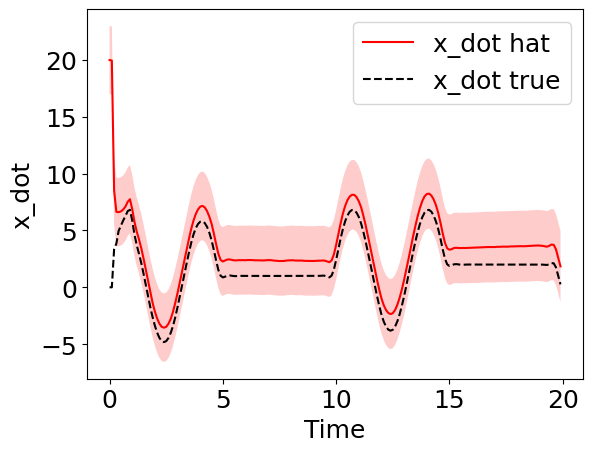

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

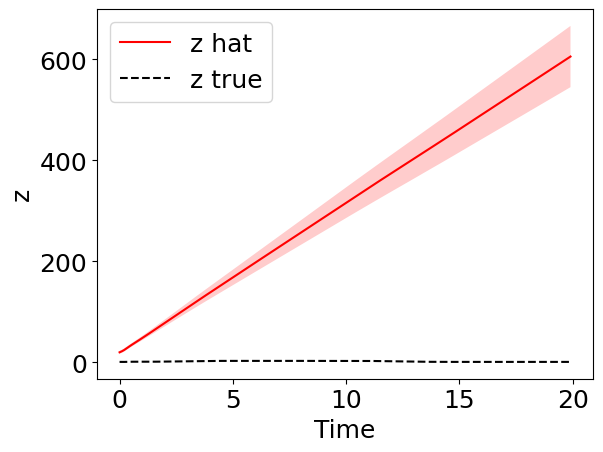

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Now we fix the UKF with some augmented information -- the AI-(U)KF

### Load our ANN estimator for altitude (z)

In [25]:
model_weights = 'altitude_estimator_ann_trained_weights.h5'
model_config = 'altitude_estimator_ann_trained_config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/altitude_estimator_ann_trained_weights.h5
Successfully downloaded altitude_estimator_ann_trained_weights.h5 (39616 bytes)
Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/altitude_estimator_ann_trained_config.json
Successfully downloaded altitude_estimator_ann_trained_config.json (338 bytes)


In [26]:
model, config = keras_ann_utility.load_model_complete('altitude_estimator_ann_trained')

✓ Loaded configuration from: altitude_estimator_ann_trained_config.json
✓ Loaded weights from: altitude_estimator_ann_trained_weights.h5

Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
fast_predict = keras_ann_utility.create_fast_inference_model(model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


### Use the ANN to generate ``raw" estimates of altitude

In a realtime application this could be done in realtime in a loop. Here we will do each step on all of the measurements at once.

### Augment the data as with the training data

In [28]:
time_window = 10
input_names = ['optic_flow', 'accel_x', 'accel_z']
input_offsets = np.arange(time_window)*-1
y_noisy_df_aug = keras_ann_utility.collect_offset_rows(y_noisy_df,
                                       states=input_names,
                                       controls=None,
                                       outputs=None,
                                       state_offsets=input_offsets,
                                       control_offsets=None,
                                       output_offsets=None)

### Get the augmented measurements $\check{x}_z$

In [29]:
z_pred = []
for i in range(len(y_noisy_df_aug)):
    y = y_noisy_df_aug.values[i,:]
    y_tf = tf.constant(np.atleast_2d(y))
    z_pred.append( fast_predict(y_tf) )
z_pred = np.ravel(tf.stack(z_pred).numpy())

### These estimates are only accurate when the min x accel in a given window is high

In [30]:
x_accel_col_names = []
for col_name in y_noisy_df_aug.keys():
  if 'accel_x' in col_name:
    x_accel_col_names.append(col_name)

In [31]:
min_accels = np.abs(y_noisy_df_aug[x_accel_col_names]).min(axis=1)

### Visualize the x-accel and the min |accel| for each window

Note that because the acceleration is oscillatory, there are moments of 0 acceleration during the oscillatory phase.

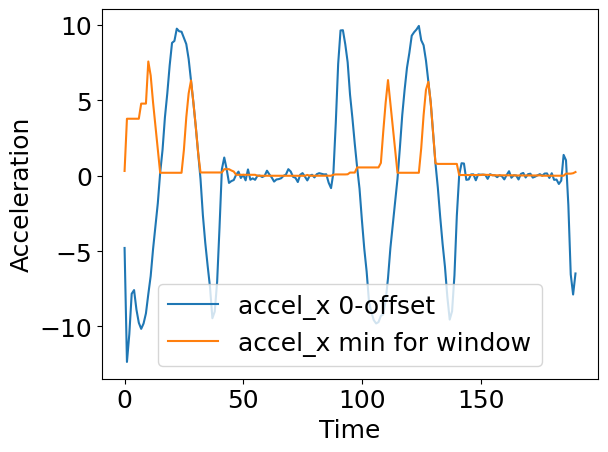

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_noisy_df_aug['accel_x_offset_0'], label='accel_x 0-offset')
ax.plot(min_accels, label='accel_x min for window')

ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

ax.legend()

### Build $\check{R}_z$: the variance for the ANN estimates of $z$

We will roughly approximate it as $\check{R}_z=\frac{1}{\min(z_w)}$.

This will depend on your system's observability properties. Here we know from our prior observability analysis that the observability of altitude is primarily (though not only) a function of the x-acceleration. The correlation in the notebook where we constructed the ANN showed a roughly 1/z relationship for the error variance.

You may need to tune this with some scaling factor.

In [33]:
R_aug_z = 1/min_accels

### The augmented information is only available after `time_window`.

We need to have collected a full time window of data, so let's pad with 0's.

In [34]:
z_pred_padded = np.hstack(([0]*(time_window-1), z_pred))
R_aug_z_padded = np.hstack(([1e8]*(time_window-1), R_aug_z))

In [35]:
# Add the augmented measurements to the augmented measurement dataframe
y_noisy_df_aug = copy.copy(y_noisy_df)
y_noisy_df_aug['z_pred'] = z_pred_padded

In [36]:
# Build a time series of R matrices
# The top left block is just our original R matrix
# The bottom right entry is our R_aug_z

# Note: for simplicity here we will ignore the off diagonal elements, which should be nonzero in some cases.
R_list = []
for i in range(y_noisy_df_aug.shape[0]):
  # initialize an augmented R matrix
  R_aug = np.eye(y_noisy_df_aug.shape[1])

  # insert the original R
  R_aug[0:y_noisy_df.shape[1], 0:y_noisy_df.shape[1]] = R
  R_aug[-1, -1] = R_aug_z_padded[i]
  R_list.append(R_aug)

In [37]:
# Package the list for compatibility
R_list_arr = np.dstack(R_list)

### Modify the h function to account for the new "measurement"

In [38]:
def h_aug(x_vec, u_vec):
  theta, theta_dot, x, x_dot, z, z_dot, k = x_vec
  y = h(x_vec, u_vec)
  y_aug = np.hstack((y, z))
  return y_aug

# Augmented Information - Unscented Kalman Filter

Run everything as above, but now with:
  * Augmented ANN measurements
  * Augmented time varing R_aug
  * Augmented measurement function

In [39]:
UKF = unscented_kalman_filter.UKF(f, h_aug, x0, u0, P0, Q, R_aug,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1)

In [40]:
UKF.estimate(y_noisy_df_aug, u_sim_df, R=R_list_arr)

In [41]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

In [42]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

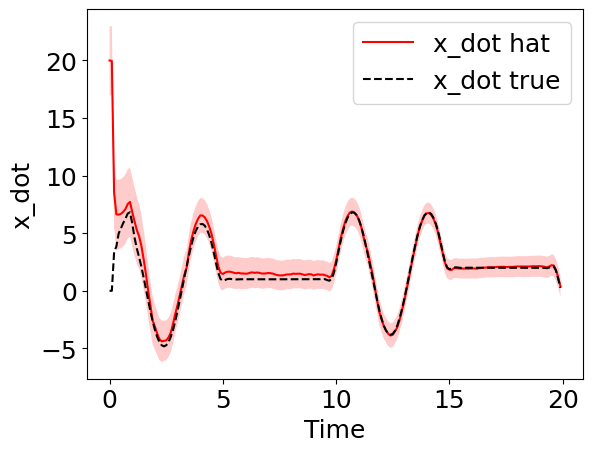

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

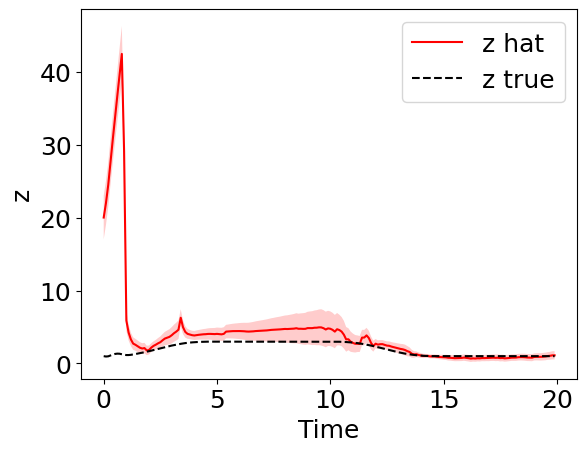

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)